In [1]:
import os

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from utils.final_model import Binnary_CNN
from utils.final_utils_binary import train, make_predictions, get_conv_layers, plot_feature_maps, plot_batch_features, plot_weights, plot_accuracy_loss
from utils.final_dataset import SingleClassCustomImageDataset

In [2]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    use_cuda = True
    print(f"Using CUDA.")

    print(f'_CUDA version: ')
    !nvcc --version
    print('*'*10)
    print(f'CUDNN version: {torch.backends.cudnn.version()}')
    print(f'Available GPU devices: {torch.cuda.device_count()}')
    print(f'Device Name: {torch.cuda.get_device_name()}')
else:
    device = torch.device('cpu')
    use_cuda = False
    print(f"Using CPU.")

PyTorch version: 2.0.1+cu118
**********
Using CUDA.
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
**********
CUDNN version: 8700
Available GPU devices: 1
Device Name: NVIDIA RTX A4000


In [3]:
# Testing
date = "230912"
model_name = "SGD_Default"
torch.manual_seed(47)
# Target classification
i_target = 0
# Assign output string for classification target and define the input directories and associated annotation files
if i_target == 0:
    input_directory = os.path.join(os.path.join(os.path.join(os.getcwd(), 'Data'), 'S7Test1D_frac'), 'Data')
    annotations_file = os.path.join(os.path.join(os.path.join(os.getcwd(), 'Data'), 'S7Test1D_frac'), 'S7Test1D_frac_class_list.csv')
    out_classification_string = "Fracture"
elif i_target == 1:
    input_directory = os.path.join(os.path.join(os.path.join(os.getcwd(), 'Data'), 'S7Test1D_rech'), 'Data')
    annotations_file = os.path.join(os.path.join(os.path.join(os.getcwd(), 'Data'), 'S7Test1D_rech'), 'S7Test1D_rech_class_list.csv')
    out_classification_string = "Recharge boundary"
elif i_target == 2:
    input_directory = os.path.join(os.path.join(os.path.join(os.getcwd(), 'Data'), 'S7Test1D_nflow'), 'Data')
    annotations_file = os.path.join(os.path.join(os.path.join(os.getcwd(), 'Data'), 'S7Test1D_nflow'), 'S7Test1D_nflow_class_list.csv')
    out_classification_string = "Impermeable boundary"
# Define important variables
batch_size = 16
number_epochs = 100
dropout_rate = 0.00
training_set_size = 0.80
# SGD hyperparameters
learning_rate = 1e-2
momentum = 0.90
# Define the image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((120,160)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) ,(0.5,))
])

In [4]:
# Define the datasets
dataset = SingleClassCustomImageDataset(annotations_file, input_directory, dataset_label_index=i_target, transform=transform, )
# Print the number of items in the full dataset
print(f"Total dataset length: {len(dataset)}")
# Get the number of training and validation images
train_number = int(len(dataset) * training_set_size)
validation_number = int(len(dataset) - train_number)
# Split the data between training and validation
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_number, validation_number])
# Print the number of items in the split datasets
print(f"    Train dataset length: {len(train_dataset)}")
print(f"    Validation dataset length: {len(validation_dataset)}")
# Load the data in batches
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
# Get the list of class options
classes_list = [f"{out_classification_string} absent", f"{out_classification_string} present"]

Total dataset length: 3221
    Train dataset length: 2576
    Validation dataset length: 645


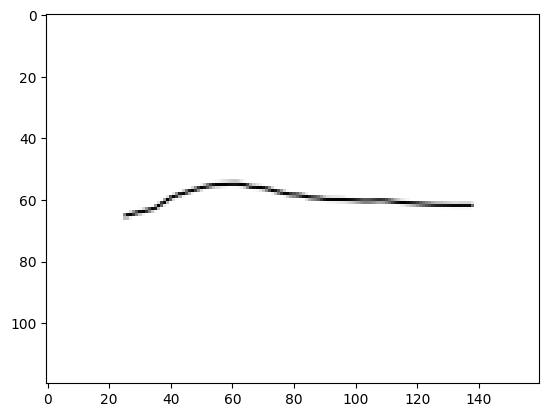

In [5]:
dl_iter = iter(train_dataloader)
dl_inputs = next(dl_iter)
plt.imshow(dl_inputs['image'][0].permute(1, 2, 0), interpolation='none', cmap='gray')

In [6]:
model = Binnary_CNN(dropout_rate).to(device)
# Create the output name for the current iteration
model_name_iter = f"{date}_{model_name}"
# Select the optimizer algorithm
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# Select to loss function
loss_func = torch.nn.BCELoss()
# Train the model
training_results = train(train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, input_model=model, optimizer=optimizer, loss_func=loss_func, scheduler=False, number_epochs=number_epochs, device=device, use_scheduler=False)

accuracies = training_results[0]
checkpoint_losses = training_results[1]

train_precision_metrics = training_results[2]
test_precision_metrics = training_results[3]
train_recall_metrics = training_results[4]
test_recall_metrics = training_results[5]
train_f1_scores = training_results[6]
test_f1_scores = training_results[7]

plot_accuracy_loss(model_name=model_name_iter, model_parameter=False, accuracies=accuracies, checkpoint_losses=checkpoint_losses)

torch.save(model.state_dict(), f'{model_name_iter}_weights.pth')
torch.save(model, f'{model_name_iter}.pth')

Epoch [1/100]:
Train accuracy: 56.4829%, Validation accuracy: 57.9845%. 
Training loss: 0.6841, Validation loss: 0.6766. 
Training precision: 0.5648, Validation precision: 0.5798. 
Training recall: 1.0000, Validation recall: 1.0000. 
Training F1 score: 0.7219, Validation F1 score: 0.7341. 

Epoch [2/100]:
Train accuracy: 56.5217%, Validation accuracy: 58.1395%. 
Training loss: 0.6774, Validation loss: 0.6593. 
Training precision: 0.5650, Validation precision: 0.5807. 
Training recall: 1.0000, Validation recall: 1.0000. 
Training F1 score: 0.7221, Validation F1 score: 0.7348. 

Epoch [3/100]:
Train accuracy: 71.0404%, Validation accuracy: 83.7209%. 
Training loss: 0.6452, Validation loss: 0.5898. 
Training precision: 0.6773, Validation precision: 0.8321. 
Training recall: 0.9306, Validation recall: 0.9011. 
Training F1 score: 0.7840, Validation F1 score: 0.8652. 

Epoch [4/100]:
Train accuracy: 82.1429%, Validation accuracy: 88.5271%. 
Training loss: 0.5860, Validation loss: 0.5105. 
Tr

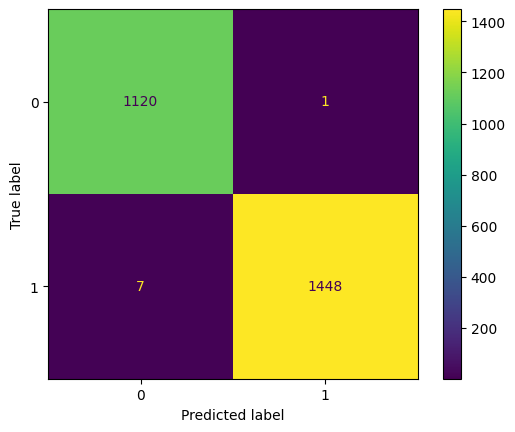

In [7]:
make_predictions(train_dataloader, model, device)

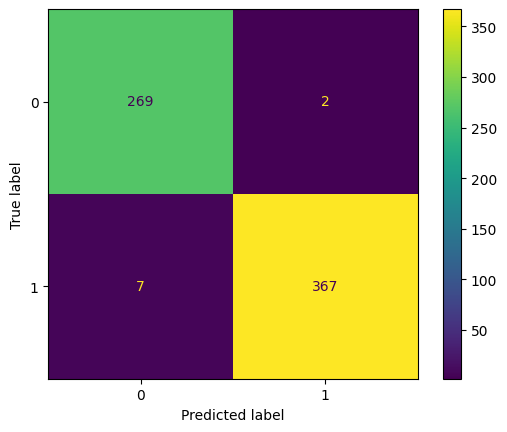

In [8]:
make_predictions(validation_dataloader, model, device)

In [9]:
conv_layers = get_conv_layers(model_children=list(model.children()))
fig_feature_maps = plot_feature_maps(input_dataloader=train_dataloader, conv_layers=conv_layers, device=device)
plt.savefig(f"{model_name_iter}_act_big_4.png")
plt.close(fig_feature_maps)

In [10]:
fig_batch = plot_batch_features(input_dataloader=train_dataloader, conv_layers=conv_layers, device=device, batch_size=batch_size, label_names=classes_list, variance=0)
plt.savefig(f"{model_name_iter}_act_4.png")
plt.close(fig_batch)

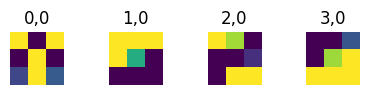

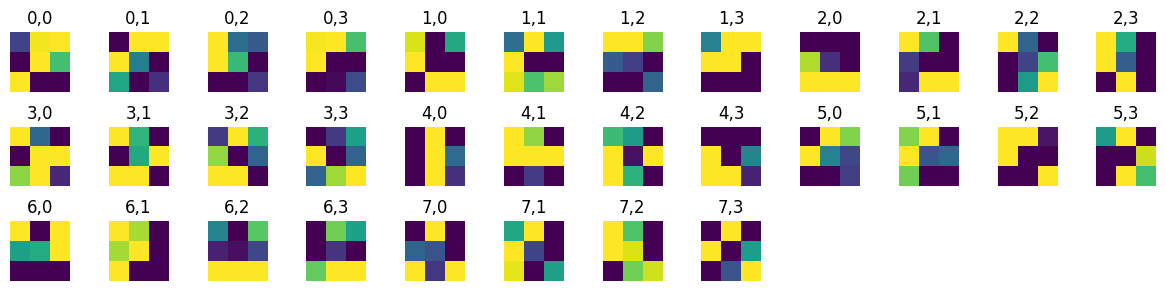

In [11]:
plot_weights(conv_layers)

In [12]:
# Define the input directories and associated annotation files
gp_input_directory = os.path.join(os.path.join(os.path.join(os.getcwd(), 'Data'), 'GroundProof'), 'Data')
gp_annotations_file = os.path.join(os.path.join(os.path.join(os.getcwd(), 'Data'), 'GroundProof'), 'GroundProof_class_list.csv')

# Define the datasets
gp_dataset = SingleClassCustomImageDataset(gp_annotations_file, gp_input_directory, dataset_label_index=i_target, transform=transform, )
# Print the number of items in the full dataset
print(f"Total dataset length: {len(gp_dataset)}")
# Load the data in batches
gp_dataloader = DataLoader(gp_dataset, batch_size=batch_size, shuffle=True)

Total dataset length: 33


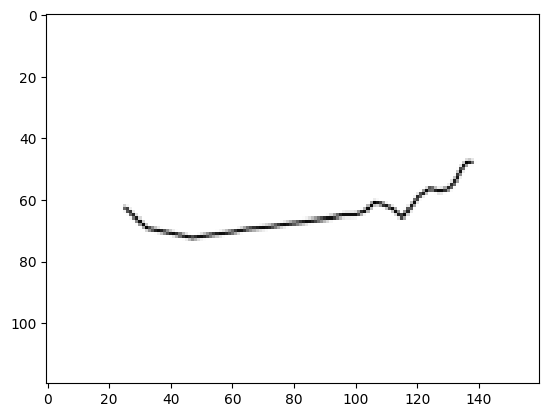

In [13]:
gp_iter = iter(gp_dataloader)
gp_inputs = next(gp_iter)
plt.imshow(gp_inputs['image'][0].permute(1, 2, 0), interpolation='none', cmap='gray')

In [14]:
fig_real_batch = plot_batch_features(input_dataloader=gp_dataloader, conv_layers=conv_layers, device=device, batch_size=batch_size, label_names=classes_list, variance=0)
plt.savefig(f"{model_name_iter}_act_real1.png")
plt.close(fig_real_batch)

In [15]:
fig_real_batch_2 = plot_batch_features(input_dataloader=gp_dataloader, conv_layers=conv_layers, device=device, batch_size=batch_size, label_names=classes_list, variance=1)
plt.savefig(f"{model_name_iter}_act_real2.png")
plt.close(fig_real_batch_2)

In [16]:
fig_real_batch_3 = plot_batch_features(input_dataloader=gp_dataloader, conv_layers=conv_layers, device=device, batch_size=batch_size, label_names=classes_list, variance=1)
plt.savefig(f"{model_name_iter}_act_real3.png")
plt.close(fig_real_batch_3)

In [17]:
fig_real_batch_4 = plot_batch_features(input_dataloader=gp_dataloader, conv_layers=conv_layers, device=device, batch_size=batch_size, label_names=classes_list, variance=0)
plt.savefig(f"{model_name_iter}_act_real4.png")
plt.close(fig_real_batch_4)

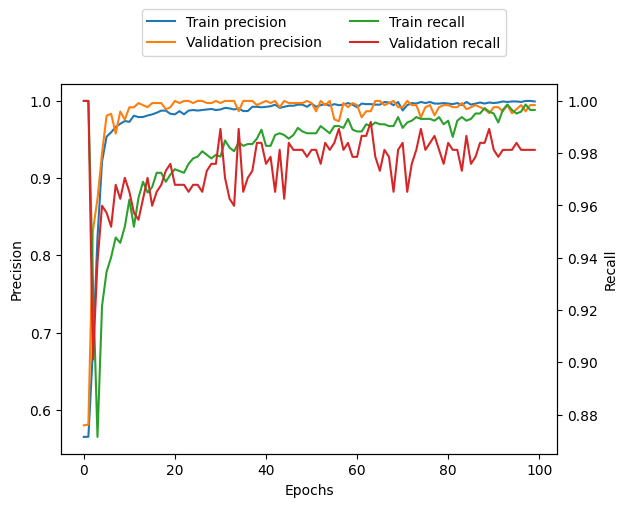

In [19]:
color_cycle = plt.rcParams['axes.prop_cycle']()

fig_losses, ax_losses = plt.subplots()
ax_losses.plot(train_precision_metrics, label="Train precision", **next(color_cycle))
ax_losses.plot(test_precision_metrics, label="Validation precision", **next(color_cycle))
ax_losses.set_xlabel('Epochs')
ax_losses.set_ylabel('Precision')

ax_accuracy = ax_losses.twinx()
ax_accuracy.plot(train_recall_metrics, label="Train recall", **next(color_cycle))
ax_accuracy.plot(test_recall_metrics, label="Validation recall", **next(color_cycle))
ax_accuracy.set_ylabel('Recall')

handles, labels = [(a + b) for a, b in zip(ax_losses.get_legend_handles_labels(), ax_accuracy.get_legend_handles_labels())]
fig_losses.legend(handles, labels, bbox_to_anchor=(0.83, 1.05), ncol=2)

fig_losses.savefig(f"{date}_{model_name}_add_met.png")

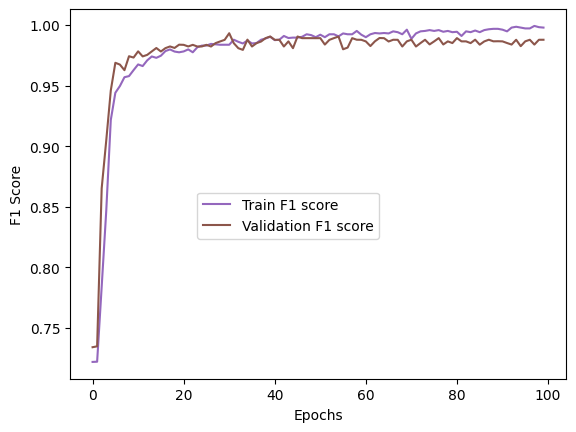

In [20]:
fig_score, ax_score = plt.subplots(dpi=100)
ax_score.plot(train_f1_scores, label="Train F1 score", **next(color_cycle))
ax_score.plot(test_f1_scores, label="Validation F1 score", **next(color_cycle))
ax_score.set_xlabel('Epochs')
ax_score.set_ylabel('F1 Score')

fig_score.legend(loc='center')
fig_score.savefig(f"{date}_{model_name}_add_F1.png")